# Flight Delay Prediction


##### **Mission**: Reduce flight delays: (1) Through 2018 data, understand what factors impacted delays (2) Anticipate a delay in 2019

Airline executives (customers) are not interested in delays caused by events out of their control, nor by previous flights, although they want to know avoidable delays. They want to use the results to avoid "predictable" delays.




## Approaches
(1) Regression (minutes delayed)

(2) Classification (whether it will be delayed by more than 15 minutes)

## The Preparations


### Installing the Libraries (can skip if already installed)

In [ ]:
!pip install rulefit
!pip install interpret
!pip install gaminet

  Preparing metadata (setup.py) ... done
  Created wheel for rulefit: filename=rulefit-0.3.1-py3-none-any.whl size=7798 sha256=a4be25079fbef3db60db8daddccd793edc28bb532e5a8036a83a3e24bc32769e
  Stored in directory: /root/.cache/pip/wheels/0c/b7/1f/c3c2e1d101b3e6095e55ae4e727dd6cf413f0e800ab38d038e
Successfully built rulefit
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 60.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.8 MB/s eta 0:00:00
 

### Loading the Libraries

In [ ]:
import math
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,\
                                  MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, naive_bayes,\
                    neighbors, ensemble, neural_network, svm

from rulefit import RuleFit
import statsmodels.api as sm

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC

import tensorflow as tf
from gaminet import GAMINet
from gaminet.utils import plot_trajectory, plot_regularization,\
                    local_visualize, global_visualize_density,\
                    feature_importance_visualize

import matplotlib.pyplot as plt

### Understanding and Preparing the Data

In [ ]:
aad18_df_origin = pd.read_csv("aa-domestic-delays-2018.csv")

In [ ]:
# The original data has aroud 900,000 samples, so will sample 10% of data for quick analysis
aad18_df=aad18_df_origin.sample(frac=0.1, random_state=42)

In [ ]:
print(aad18_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 89953 entries, 51077 to 26727
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   FL_NUM                89953 non-null  int64  
 1   ORIGIN                89953 non-null  object 
 2   DEST                  89953 non-null  object 
 3   PLANNED_DEP_DATETIME  89953 non-null  object 
 4   CRS_DEP_TIME          89953 non-null  int64  
 5   DEP_TIME              89953 non-null  float64
 6   DEP_DELAY             89953 non-null  float64
 7   DEP_AFPH              89953 non-null  float64
 8   DEP_RFPH              89953 non-null  float64
 9   TAXI_OUT              89953 non-null  float64
 10  WHEELS_OFF            89953 non-null  float64
 11  CRS_ELAPSED_TIME      89953 non-null  float64
 12  PCT_ELAPSED_TIME      89953 non-null  float64
 13  DISTANCE              89953 non-null  float64
 14  CRS_ARR_TIME          89953 non-null  int64  
 15  ARR_AFPH            

In [ ]:
print(aad18_df.head())

        FL_NUM ORIGIN DEST PLANNED_DEP_DATETIME  CRS_DEP_TIME  DEP_TIME  \
51077      539    RSW  PHL  2018-01-23 07:00:00           700     649.0   
861060    1656    CLE  PHL  2018-12-16 05:56:00           556     546.0   
157216    2637    PHX  SNA  2018-03-08 21:20:00          2120    2125.0   
806636     873    DFW  MKE  2018-11-23 10:40:00          1040    1039.0   
201035     487    CLT  SAN  2018-03-26 09:20:00           920     915.0   

        DEP_DELAY    DEP_AFPH  DEP_RFPH  TAXI_OUT  ...  DISTANCE  \
51077       -11.0    8.571429  1.428571      15.0  ...     993.0   
861060      -10.0   12.000000  1.500000      19.0  ...     363.0   
157216        5.0   64.615385  1.059269      25.0  ...     338.0   
806636       -1.0  120.000000  1.263158      17.0  ...     853.0   
201035       -5.0   72.000000  0.862275      15.0  ...    2077.0   

        CRS_ARR_TIME   ARR_AFPH  ARR_RFPH  ARR_DELAY  CARRIER_DELAY  \
51077            942  30.000000  1.071429      -24.0            0.0  

In [ ]:
aad18_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
FL_NUM,89953.0,1515.902927,784.313660,1.000000,802.000000,1599.000000,2183.000000,2834.000000
CRS_DEP_TIME,89953.0,1315.841217,500.761264,1.000000,859.000000,1308.000000,1730.000000,2359.000000
DEP_TIME,89953.0,1322.287784,514.149291,1.000000,859.000000,1315.000000,1742.000000,2400.000000
DEP_DELAY,89953.0,10.145832,44.696085,-31.000000,-5.000000,-2.000000,6.000000,1568.000000
DEP_AFPH,89953.0,55.095476,35.554919,0.000000,25.090909,49.615385,82.258065,204.230769
DEP_RFPH,89953.0,1.101872,0.498867,0.000000,0.946154,1.039206,1.153846,28.562874
TAXI_OUT,89953.0,18.776528,9.848105,3.000000,13.000000,16.000000,21.000000,172.000000
WHEELS_OFF,89953.0,1346.276367,516.110722,1.000000,917.000000,1330.000000,1756.000000,2400.000000
CRS_ELAPSED_TIME,89953.0,171.128556,79.341778,43.000000,112.000000,158.000000,209.000000,570.000000
PCT_ELAPSED_TIME,89953.0,0.972087,0.105999,0.558442,0.915789,0.961988,1.012469,4.459459


#### Describe features
* General features:
 *   FL_NUM: Flight number.
 *   ORIGIN: Starting airport code (IATA).
 *   DEST: Destination airport code (IATA).
* Departure features:
 * PLANNED_DEP_DATETIME: The planned date and time of the flight.
 * CRS_DEP_TIME: The planned departure time.
 * DEP_TIME: The actual departure time.
 * DEP_AFPH: The number of actual flights per hour occurring during the interval in between the planned and actual departure from the origin airport (factoring in 30 minutes of padding). The feature tells you how busy the origin airport was during takeoff.
 * DEP_RFPH: The departure relative flights per hour is the ratio of actual flights per hour over the median number of flights per hour that occur at the origin airport at that time of day, day of the week, and month of the year. The feature tells you how relatively busy the origin airport was during takeoff.
 * TAXI_OUT: The time duration elapsed between the departure from the origin airport gate and wheels off.
 * WHEELS_OFF: The point in time that the aircraft’s wheels leave the ground.
* In-flight features:
 * CRS_ELAPSED_TIME: The planned amount of time needed for the flight trip.
 * PCT_ELAPSED_TIME: The ratio of actual flight time over planned flight time to gauge the plane’s relative speed.
 * DISTANCE: The distance between two airports.
* Arrival features:
 * CRS_ARR_TIME: The planned arrival time.
 * ARR_AFPH: The number of actual flights per hour occurring during the interval between the planned and actual arrival time at the destination airport (factoring in 30 minutes of padding). The feature tells you how busy the destination airport was during landing.
 * ARR_RFPH: The arrival relative flights per hour is the ratio of actual flights per hour over the median number of flights per hour that occur at the destination airport at that time of day, day of the week, and month of the year. The feature tells you how relatively busy the destination airport was during landing.
* Delay features:
 * DEP_DELAY: The total delay on departure in minutes.
 * ARR_DELAY: The total delay on arrival in minutes can be subdivided into any or all of the following:
    * CARRIER_DELAY: The delay in minutes caused by circumstances within the airline’s control (for example, maintenance or crew problems, aircraft cleaning, baggage loading, fueling, and so on).
    * WEATHER_DELAY: The delay in minutes caused by significant meteorological conditions (actual or forecasted).
    * NAS_DELAY: The delay in minutes mandated by a national aviation system such as non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control.
    * SECURITY_DELAY: The delay in minutes caused by the evacuation of a terminal or concourse, re-boarding of an aircraft because of a security breach, faulty screening equipment, or long lines above 29 minutes in screening areas.
    * LATE_AIRCRAFT_DELAY: The delay in minutes caused by a previous flight with the same aircraft that arrived late.

In [ ]:
# Change the format so that it can extract month and dayof week. Without this code, cannot extract month or day of week
aad18_df['PLANNED_DEP_DATETIME'] = pd.to_datetime(aad18_df['PLANNED_DEP_DATETIME'])
# Create month and day of week colums
aad18_df['DEP_MONTH'] = aad18_df['PLANNED_DEP_DATETIME'].dt.month
aad18_df['DEP_DOW'] = aad18_df['PLANNED_DEP_DATETIME'].dt.dayofweek

# After create relavant data, drop the unnecessary column
aad18_df = aad18_df.drop(['PLANNED_DEP_DATETIME'], axis=1)

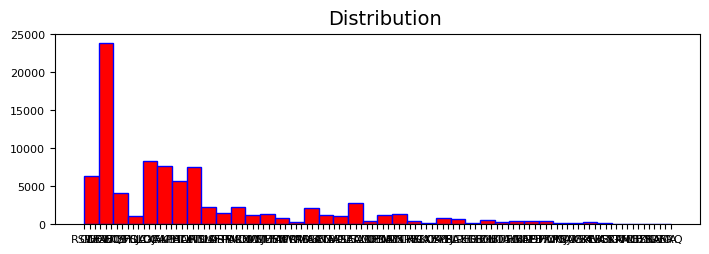

In [ ]:
# Check feature distribution
aad18_df['ORIGIN'].hist(bins=40, edgecolor='b', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False, figsize=(6,2), color='red')
plt.tight_layout(rect=(0, 0, 1.2, 1.2))
plt.suptitle('Distribution', x=0.65, y=1.25, fontsize=14);

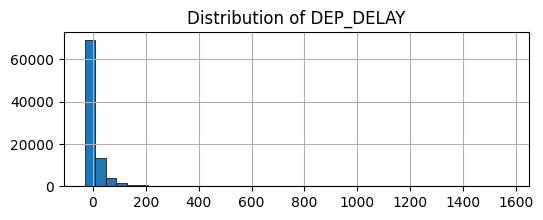

In [ ]:
numeric_features = ['DEP_DELAY']
for col in numeric_features:
    aad18_df[col].hist(bins=40, edgecolor='k', linewidth=0.5, figsize=(6,2))
    plt.title(f'Distribution of {col}')
    plt.show()


In [ ]:
#Create list with 10 hubs
hubs = ['CLT', 'ORD', 'DFW', 'LAX', 'MIA', 'JFK', 'LGA', 'PHL',\
        'PHX', 'DCA']

#Boolean series for if ORIGIN or DEST are hubs (textbook had a typo)
is_origin_hub = aad18_df['ORIGIN'].isin(hubs)
is_dest_hub = aad18_df['DEST'].isin(hubs)

#Use boolean series to set ORIGIN_HUB and DEST_HUB
aad18_df['ORIGIN_HUB'] = 0
aad18_df.loc[is_origin_hub, 'ORIGIN_HUB'] = 1
aad18_df['DEST_HUB'] = 0
aad18_df.loc[is_dest_hub, 'DEST_HUB'] = 1

#Delete columns with codes
aad18_df = aad18_df.drop(['FL_NUM', 'ORIGIN', 'DEST'], axis=1)

#### Remove some features

In [ ]:
#investigate the total delay and carrier delay
aad18_df.loc[aad18_df['ARR_DELAY'] > 15, ['ARR_DELAY','CARRIER_DELAY']].head(20)

,ARR_DELAY,CARRIER_DELAY
336130,20.0,0.0
376022,17.0,6.0
18967,39.0,0.0
741474,31.0,14.0
221346,24.0,0.0
731063,29.0,9.0
810013,191.0,190.0
65143,70.0,0.0
837238,24.0,24.0
219581,21.0,0.0


In [ ]:
aad18_df = aad18_df.drop(['ARR_DELAY'], axis=1)

In [ ]:
# Now set the carrier delay as a target
rand = 9
np.random.seed(rand)

y = aad18_df['CARRIER_DELAY']
X = aad18_df.drop(['CARRIER_DELAY'], axis=1).copy()
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.15, random_state=rand)
y_train_class = y_train_reg.apply(lambda x: 1 if x > 15 else 0)
y_test_class = y_test_reg.apply(lambda x: 1 if x > 15 else 0)

In [ ]:
corr = aad18_df.corr()
abs(corr['CARRIER_DELAY']).sort_values(ascending=False)

,CARRIER_DELAY
CARRIER_DELAY,1.000000
DEP_DELAY,0.717401
LATE_AIRCRAFT_DELAY,0.103034
ARR_RFPH,0.076111
DEP_RFPH,0.060770
NAS_DELAY,0.034991
TAXI_OUT,0.030177
ARR_AFPH,0.029657
DEP_TIME,0.028744
PCT_ELAPSED_TIME,0.028429


## Reviewing Traditional Model Interpretation Methods

### Predicting **Minutes** Delayed with Various Regression Methods

#### Training and Evaluating the Regression Models
* linear: Linear regression.
* linear_poly: Polynomial regression extends linear regression by adding polynomial features. (degree=2 means quadratic).
* linear_interact: Polynomial regression model but without the quadratic terms.
* ridge: Ridge regression is a variation of linear regression, by reducing the complexity added by the introduction of too many features.
* decision_tree: A decision tree.
* rule_fit: RuleFit is a regularized linear regression expanded to include feature interactions in the form of rules.
* knn: k-Nearest Neighbors (k-NN) determine the class based on their k-nearest neighbors.
* random_forest: Random forest takes an average of hundreads of randomly generated decision trees to create the best tree.
* mlp: A multi-layer perceptron is a “vanilla” feedforward (sequential) neural network.

In [ ]:
reg_models = {
        #Generalized Linear Models (GLMs)
        'linear':{'model': linear_model.LinearRegression()},
        'linear_poly':{'model': make_pipeline(PolynomialFeatures(degree=2),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'linear_interact':{'model': make_pipeline(PolynomialFeatures(interaction_only=True),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'ridge':{'model': linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]) },
        #Trees
        'decision_tree':{'model': tree.DecisionTreeRegressor(max_depth=7, random_state=rand)},
        #RuleFit
        'rulefit':{'model': RuleFit(max_rules=150, rfmode='regress', random_state=rand)},
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsRegressor(n_neighbors=7)},
        #Ensemble Methods
        'random_forest':{'model':ensemble.RandomForestRegressor(max_depth=7, random_state=rand)},
        #Neural Networks
        'mlp':{'model':neural_network.MLPRegressor(hidden_layer_sizes=(21,), max_iter=500,
                                                   early_stopping=True, random_state=rand)}
    }

In [ ]:

%%time
for model_name in reg_models.keys():
    print(model_name)
    if model_name != 'rulefit':
        fitted_model = reg_models[model_name]['model'].fit(X_train, y_train_reg)
        y_train_pred = fitted_model.predict(X_train)
        y_test_pred = fitted_model.predict(X_test)
    else:
        fitted_model = reg_models[model_name]['model'].fit(X_train.values, y_train_reg.values, X_test.columns)
        y_train_pred = fitted_model.predict(X_train.values)
        y_test_pred = fitted_model.predict(X_test.values)
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] = math.sqrt(metrics.mean_squared_error(y_train_reg, y_train_pred))
    reg_models[model_name]['RMSE_test'] = math.sqrt(metrics.mean_squared_error(y_test_reg, y_test_pred))
    reg_models[model_name]['R2_test'] = metrics.r2_score(y_test_reg, y_test_pred)

linear
linear_poly
linear_interact
ridge
decision_tree
rulefit


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5247.348046681844, tolerance: 4530.769145940057
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5475.498200515285, tolerance: 4530.769145940057
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18140.30588181503, tolerance: 4530.769145940057
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWar

knn
random_forest
mlp
CPU times: user 2min 2s, sys: 2.27 s, total: 2min 4s
Wall time: 1min 55s


#### Evaluate with various evaluation metrics
* RMSE: Root Mean Square Error
* R2: R-squared.

In [ ]:
reg_metrics = pd.DataFrame.from_dict(reg_models, 'index')[['RMSE_train', 'RMSE_test', 'R2_test']]
reg_metrics.sort_values(by='RMSE_test').style.format({'RMSE_train':\
                '{:.2f}', 'RMSE_test': '{:.2f}', 'R2_test': '{:.3f}'}).\
    background_gradient(cmap='viridis_r', low=0.1, high=1, subset=['RMSE_train', 'RMSE_test']).\
    background_gradient(cmap='plasma', low=0.1, high=1, subset=['R2_test'])

,RMSE_train,RMSE_test,R2_test
mlp,3.97,3.89,0.972
linear_poly,6.05,6.04,0.933
linear_interact,6.34,6.24,0.929
random_forest,5.20,7.22,0.904
linear,7.92,7.62,0.894
ridge,7.92,7.62,0.894
decision_tree,6.57,8.74,0.860
rulefit,9.93,10.78,0.787
knn,14.32,12.27,0.724


### Classifying Flights as Delayed or Not Delayed with Various Classification Methods

#### Training and Evaluating the Classification Models
* logistic: logistic regression.
* ridge: Ridge classification.
* decision_tree
* knn: k-NN
* naive_bayes
* gradient_boosting
* random_forest
* mlp

In [ ]:
class_models = {
        #Generalized Linear Models (GLMs)
        'logistic':{'model': linear_model.LogisticRegression()},
        'ridge':{'model': linear_model.RidgeClassifierCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1],\
                                                         class_weight='balanced')},
        #Tree
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=7, random_state=rand)},
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsClassifier(n_neighbors=7)},
        #Naive Bayes
        'naive_bayes':{'model': naive_bayes.GaussianNB()},
        #Ensemble Methods
        'gradient_boosting':{'model':ensemble.GradientBoostingClassifier(n_estimators=210)},
        'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=11,\
                                                                 class_weight='balanced', random_state=rand)},
        #Neural Networks
        'mlp':{'model':make_pipeline(StandardScaler(),\
                                     neural_network.MLPClassifier(hidden_layer_sizes=(7,), max_iter=500,\
                                                   early_stopping=True, random_state=rand))}
    }

In [ ]:
print(y_train_class[y_train_class==1].shape[0] / y_train_class.shape[0])

0.062123986398116664


In [ ]:
%%time
for model_name in class_models.keys():
    print(model_name)
    fitted_model = class_models[model_name]['model'].fit(X_train, y_train_class)
    y_train_pred = fitted_model.predict(X_train)
    if model_name == 'ridge':
        y_test_pred = fitted_model.predict(X_test)
    else:
        y_test_prob = fitted_model.predict_proba(X_test)[:,1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['probs'] = y_test_prob
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] = metrics.accuracy_score(y_train_class, y_train_pred)
    class_models[model_name]['Accuracy_test'] = metrics.accuracy_score(y_test_class, y_test_pred)
    class_models[model_name]['Recall_train'] = metrics.recall_score(y_train_class, y_train_pred)
    class_models[model_name]['Recall_test'] = metrics.recall_score(y_test_class, y_test_pred)
    if model_name != 'ridge':
        class_models[model_name]['ROC_AUC_test'] = metrics.roc_auc_score(y_test_class, y_test_prob)
    else:
        class_models[model_name]['ROC_AUC_test'] = np.nan
    class_models[model_name]['F1_test'] = metrics.f1_score(y_test_class, y_test_pred)
    class_models[model_name]['MCC_test'] = metrics.matthews_corrcoef(y_test_class, y_test_pred)

logistic


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ridge
decision_tree
knn
naive_bayes
gradient_boosting
random_forest
mlp
CPU times: user 1min 55s, sys: 295 ms, total: 1min 55s
Wall time: 1min 48s


In [ ]:
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                                               'Recall_train', 'Recall_test',\
                                                               'ROC_AUC_test', 'F1_test', 'MCC_test']]
class_metrics.sort_values(by='ROC_AUC_test', ascending=False).style.\
    format(dict(zip(class_metrics.columns, ['{:.3f}']*7))).\
    background_gradient(cmap='plasma', low=1, high=0.1, subset=['Accuracy_train', 'Accuracy_test']).\
    background_gradient(cmap='viridis', low=1, high=0.1, subset=['Recall_train', 'Recall_test',\
                                                                 'ROC_AUC_test', 'F1_test', 'MCC_test'])

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,ROC_AUC_test,F1_test,MCC_test
mlp,0.996,0.995,0.963,0.952,0.999,0.959,0.956
gradient_boosting,0.993,0.991,0.914,0.897,0.999,0.927,0.924
random_forest,0.953,0.949,1.000,0.979,0.993,0.701,0.710
decision_tree,0.984,0.982,0.859,0.846,0.993,0.852,0.843
logistic,0.975,0.974,0.698,0.669,0.956,0.759,0.753
knn,0.959,0.949,0.467,0.348,0.874,0.455,0.455
naive_bayes,0.920,0.918,0.295,0.265,0.801,0.284,0.241
ridge,0.886,0.885,0.772,0.757,nan,0.446,0.441


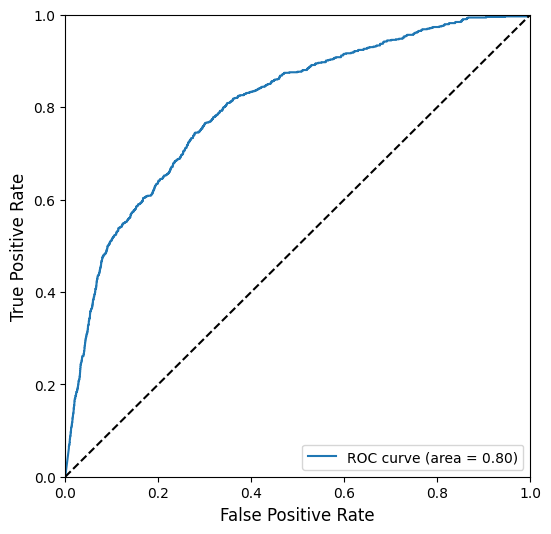

In [ ]:
plt.figure(figsize = (6,6), dpi=100)
plt.tick_params(axis = 'both', which = 'major', labelsize = 10)
fpr, tpr, _ = metrics.roc_curve(y_test_class, class_models['naive_bayes']['probs'])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % class_models['naive_bayes']['ROC_AUC_test'])
plt.plot([0, 1], [0, 1], 'k--')  # coin toss line
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")
plt.show()

## Studying Intrinsically interpretable (White-box) models

### Generalized Linear Models (GLMs)

#### Linear Regression

In [ ]:
coefs_lm = reg_models['linear']['fitted'].coef_
intercept_lm = reg_models['linear']['fitted'].intercept_
print('coefficients:\t%s' % coefs_lm)
print('intercept:\t%s' % intercept_lm)

coefficients:	[ 4.12839029e-03 -4.56004232e-03  9.00318398e-01 -1.49694394e-02
 -4.52044523e-01  1.29417576e-01 -7.72933319e-04 -1.48673804e-02
  4.71631698e+01  9.76548807e-04 -4.45232633e-04  4.42730641e-04
  1.85361179e-01 -9.10751322e-01 -6.92006173e-01 -9.90480834e-01
 -9.35257608e-01 -3.60700858e-02 -2.79714170e-02 -1.13366041e+00
 -4.11131344e-01]
intercept:	-39.73475951759247


In [ ]:
print('ŷ = %0.2f + %0.4fX₁ + %0.4fX₂ + %0.3fX₃ + ...' %\
      (intercept_lm, coefs_lm[0], coefs_lm[1], coefs_lm[2]))

ŷ = -39.73 + 0.0041X₁ + -0.0046X₂ + 0.900X₃ + ...


In [ ]:
pd.DataFrame({'feature':X_train.columns.tolist(),\
                        'coef': coefs_lm.tolist()})

,feature,coef
0,CRS_DEP_TIME,0.004128
1,DEP_TIME,-0.004560
2,DEP_DELAY,0.900318
3,DEP_AFPH,-0.014969
4,DEP_RFPH,-0.452045
5,TAXI_OUT,0.129418
6,WHEELS_OFF,-0.000773
7,CRS_ELAPSED_TIME,-0.014867
8,PCT_ELAPSED_TIME,47.163170
9,DISTANCE,0.000977


##### How to compute feature importance?
1.   Divide the coefficient by their corresponding std error, then take the absolute value and sort. In this case, you need the std error.
2.   Using statsmodels library, OLS: Ordinary Least Squares, used to optimize the coefficients.



In [ ]:
linreg_mdl = sm.OLS(y_train_reg, sm.add_constant(X_train))
linreg_mdl = linreg_mdl.fit()
print(linreg_mdl.summary())

                            OLS Regression Results                            
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                 4.576e+04
Date:                Fri, 18 Jul 2025   Prob (F-statistic):               0.00
Time:                        06:34:20   Log-Likelihood:            -2.6671e+05
No. Observations:               76460   AIC:                         5.335e+05
Df Residuals:                   76438   BIC:                         5.337e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -39.7348    

In [ ]:
summary_df = linreg_mdl.summary2().tables[1]
summary_df = summary_df.drop(['const']).reset_index().rename(columns={'index':'feature'})
summary_df['t_abs'] = abs(summary_df['t'])
summary_df.sort_values(by='t_abs', ascending=False).style.\
    format(dict(zip(summary_df.columns[1:], ['{:.4f}']*7))).\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['P>|t|','t_abs'])

,feature,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],t_abs
2,DEP_DELAY,0.9003,0.0009,968.3209,0.0000,0.8985,0.9021,968.3209
16,LATE_AIRCRAFT_DELAY,-0.9353,0.0016,-577.5802,0.0000,-0.9384,-0.9321,577.5802
13,WEATHER_DELAY,-0.9108,0.0033,-278.9220,0.0000,-0.9172,-0.9044,278.9220
14,NAS_DELAY,-0.6920,0.0025,-272.2999,0.0000,-0.6970,-0.6870,272.2999
8,PCT_ELAPSED_TIME,47.1632,0.3742,126.0440,0.0000,46.4298,47.8966,126.0440
5,TAXI_OUT,0.1294,0.0038,33.7087,0.0000,0.1219,0.1369,33.7087
15,SECURITY_DELAY,-0.9905,0.0325,-30.5188,0.0000,-1.0541,-0.9269,30.5188
0,CRS_DEP_TIME,0.0041,0.0002,18.2811,0.0000,0.0037,0.0046,18.2811
1,DEP_TIME,-0.0046,0.0003,-16.0370,0.0000,-0.0051,-0.0040,16.0370
3,DEP_AFPH,-0.0150,0.0010,-14.6240,0.0000,-0.0170,-0.0130,14.6240


#### Ridge Regression

In [ ]:
coefs_ridge = reg_models['ridge']['fitted'].coef_
coef_ridge_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'coef_linear': coefs_lm,\
                        'coef_ridge': coefs_ridge})
coef_ridge_df['coef_regularization'] = coef_ridge_df['coef_linear'] - coef_ridge_df['coef_ridge']
coef_ridge_df.style.\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['coef_regularization'])

,feature,coef_linear,coef_ridge,coef_regularization
0,CRS_DEP_TIME,0.004128,0.004173,-0.000045
1,DEP_TIME,-0.004560,-0.004522,-0.000038
2,DEP_DELAY,0.900318,0.900366,-0.000047
3,DEP_AFPH,-0.014969,-0.014977,0.000007
4,DEP_RFPH,-0.452045,-0.452044,-0.000000
5,TAXI_OUT,0.129418,0.129418,-0.000001
6,WHEELS_OFF,-0.000773,-0.000761,-0.000011
7,CRS_ELAPSED_TIME,-0.014867,-0.014873,0.000006
8,PCT_ELAPSED_TIME,47.163170,47.163065,0.000105
9,DISTANCE,0.000977,0.000934,0.000042


In [ ]:
# Observe how the coefficients are changing based on the alphas
num_alphas = 100
alphas = np.logspace(0, 13, num_alphas)
alphas_coefs = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha).fit(X_train, y_train_reg)
    alphas_coefs.append(np.concatenate((ridge.coef_[:8],ridge.coef_[9:])))

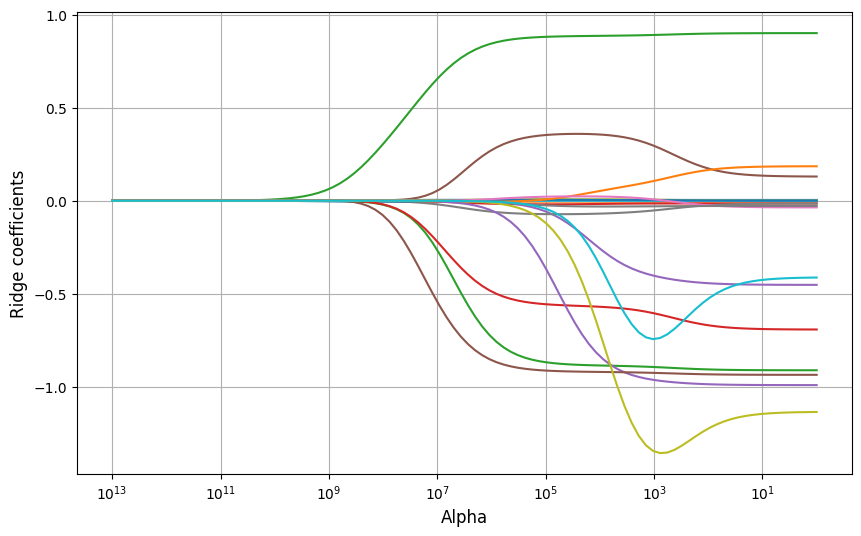

In [ ]:
plt.figure(figsize = (10,6), dpi=100)
plt.gca().invert_xaxis()
plt.tick_params(axis = 'both', which = 'major', labelsize = 10)
plt.plot(alphas, alphas_coefs)
plt.xscale("log")
plt.xlabel('Alpha', fontsize = 12)
plt.ylabel('Ridge coefficients', fontsize = 12)
plt.grid()
plt.show()

#### Polynomial Regression
It is not practical to understand a formular with 253 terms. However, it still can be interpreted in all other scopes, for example, separating the effects of the features, etc. Or can use statistical testing. In any way, the methods are model specific.

In [ ]:
print(reg_models['linear_poly']['fitted'].get_params()['linearregression'].coef_.shape[0])

253


In [ ]:
print(reg_models['linear_interact']['fitted'].get_params()['linearregression'].coef_.shape[0])

232


#### Logistic Regression
Various feature importance calculations exist, and the simplest is to investigate the coefficients.

In [ ]:
coefs_log = class_models['logistic']['fitted'].coef_
intercept_log = class_models['logistic']['fitted'].intercept_
print('coefficients:\t%s' % coefs_log)
print('intercept:\t%s' % intercept_log)

coefficients:	[[-6.76573411e-04 -1.92068656e-05  1.64714511e-01  1.41227013e-02
  -2.13726959e-03  6.47893751e-04 -8.54725602e-05 -5.32696890e-02
  -1.86100116e-03  5.45562184e-03 -6.55153030e-04 -2.56930859e-03
  -3.28881803e-03 -1.45532292e-01 -1.30015819e-01 -2.18921850e-03
  -1.71289842e-01 -1.29437098e-02 -5.80484038e-03  6.84907605e-04
  -2.29732926e-03]]
intercept:	[-0.00234537]


In [ ]:
stdv = np.std(X_train, 0)
abs(coefs_log.reshape(21,) * stdv).sort_values(ascending=False)

,0
DEP_DELAY,7.479336
LATE_AIRCRAFT_DELAY,4.237608
CRS_ELAPSED_TIME,4.226937
DISTANCE,3.546273
NAS_DELAY,1.833686
WEATHER_DELAY,1.339407
DEP_AFPH,0.502202
CRS_ARR_TIME,0.346676
CRS_DEP_TIME,0.338840
ARR_AFPH,0.090969


### Decision Trees

#### CART Decision Trees
Classification and Regression Trees (CART)

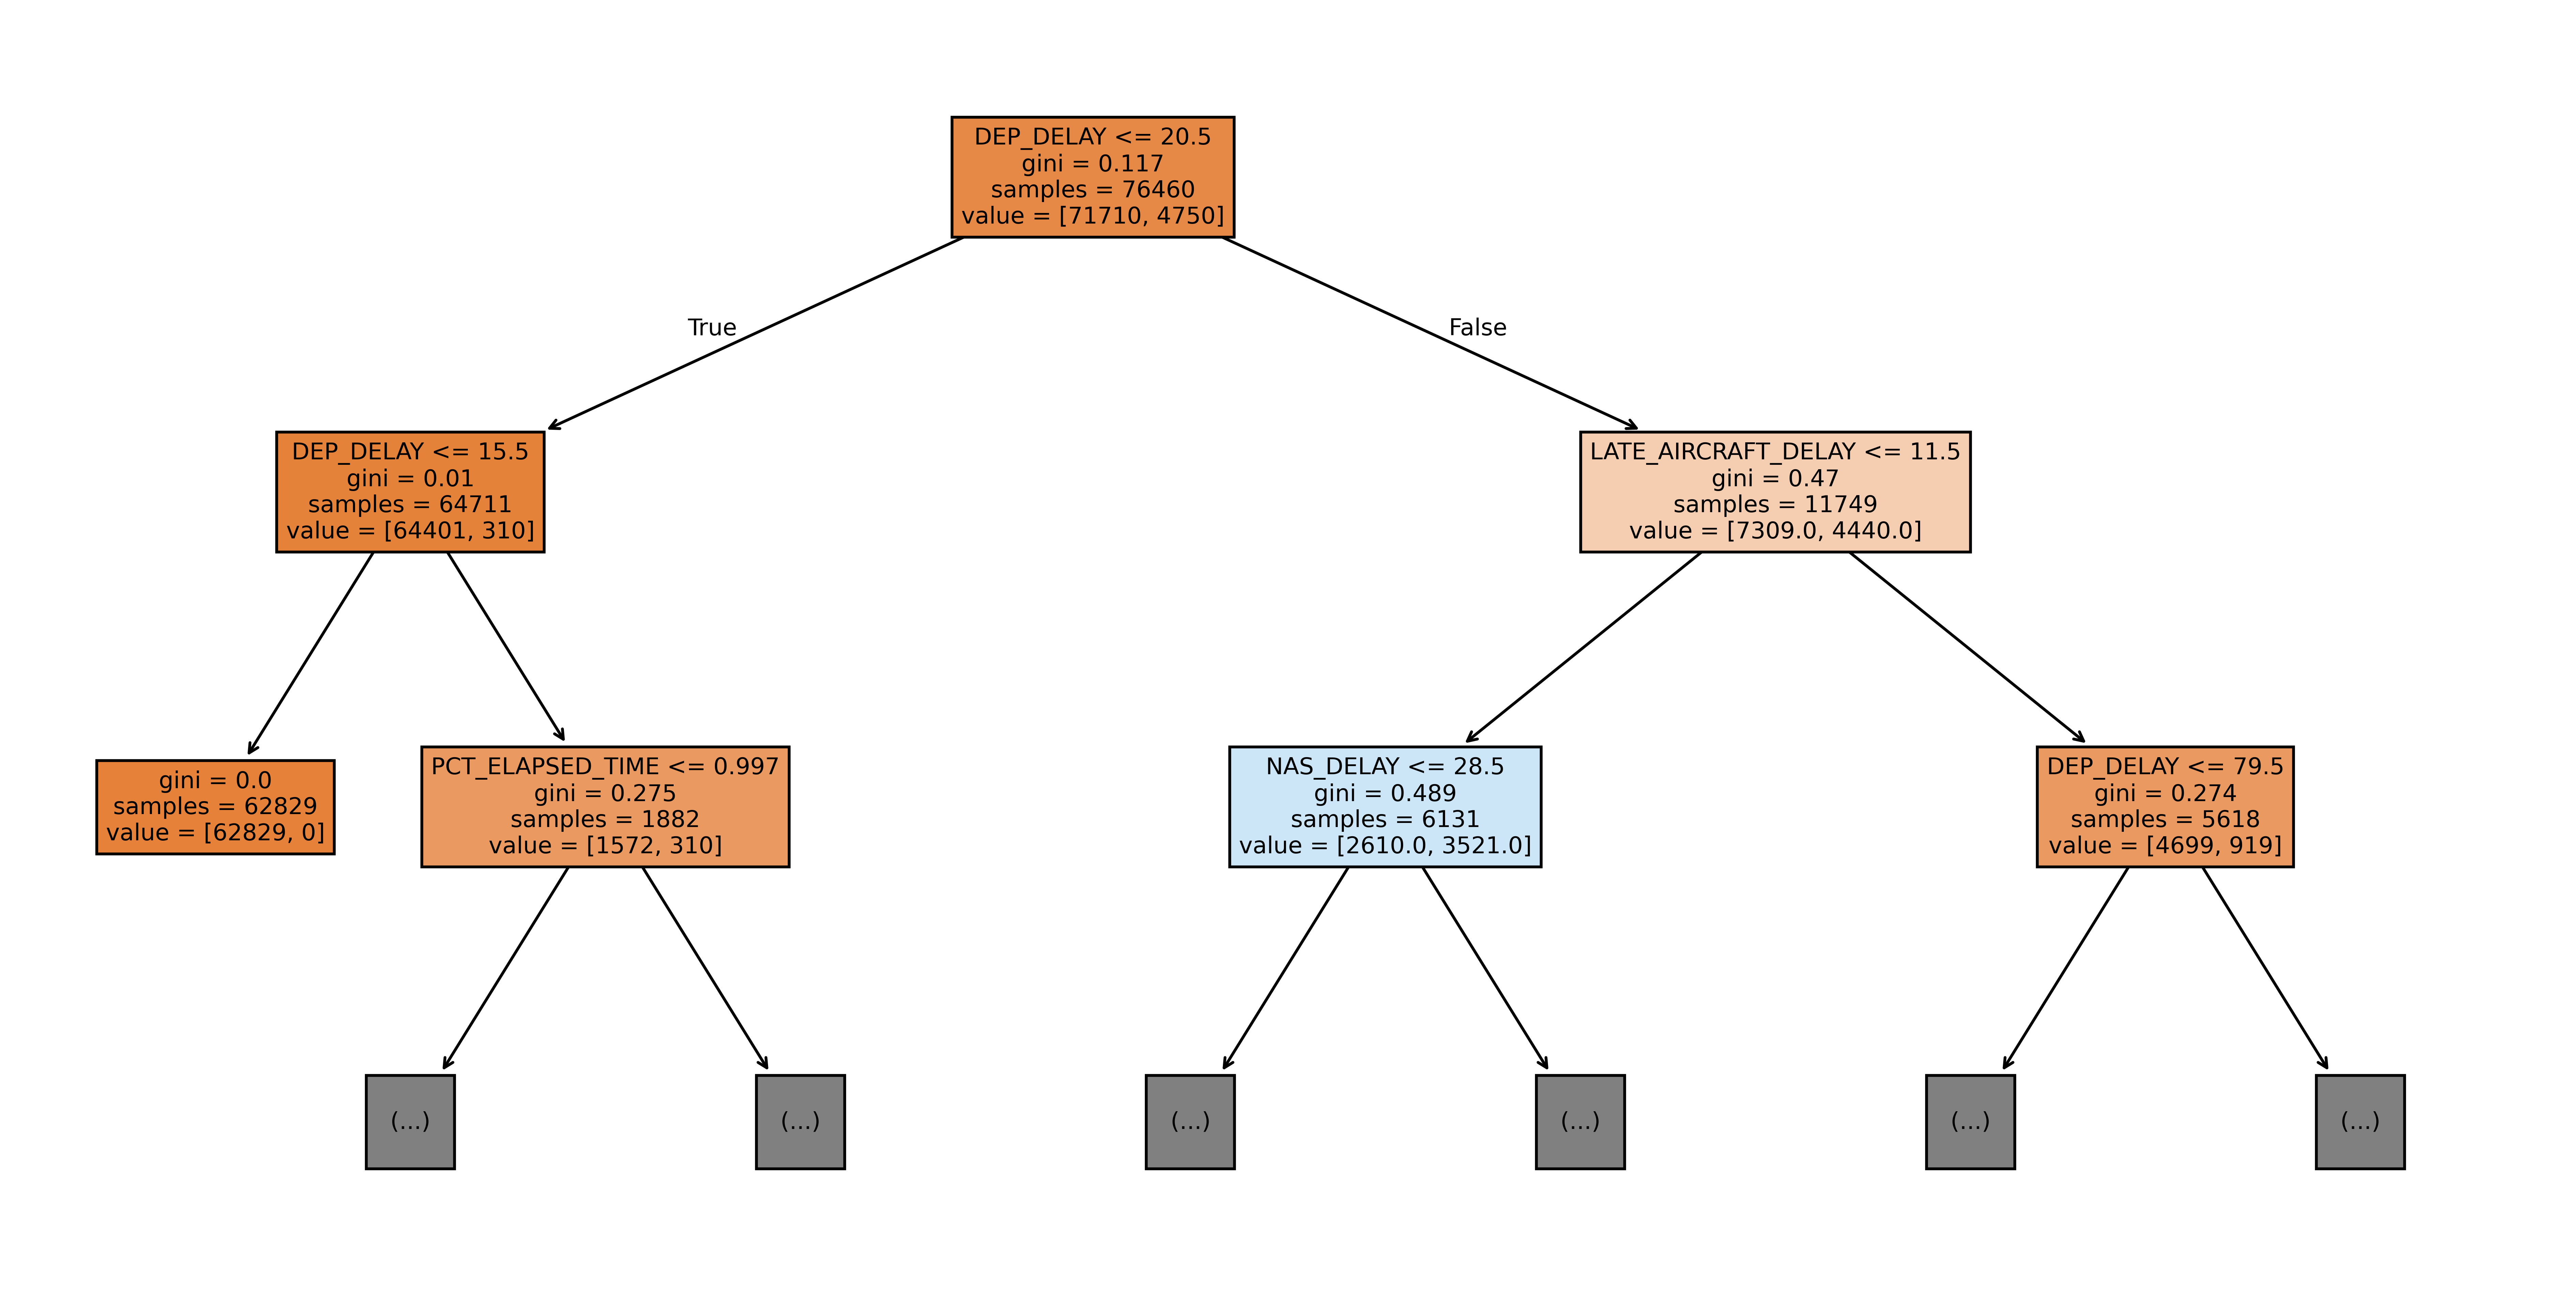

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=600)
tree.plot_tree(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist(), filled = True, max_depth=2)
fig.show()

In [ ]:
text_tree = tree.export_text(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist())
print(text_tree)

|--- DEP_DELAY <= 20.50
|   |--- DEP_DELAY <= 15.50
|   |   |--- class: 0
|   |--- DEP_DELAY >  15.50
|   |   |--- PCT_ELAPSED_TIME <= 1.00
|   |   |   |--- PCT_ELAPSED_TIME <= 0.98
|   |   |   |   |--- CRS_ELAPSED_TIME <= 63.50
|   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.94
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.94
|   |   |   |   |   |   |--- DEP_DELAY <= 18.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- DEP_DELAY >  18.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- CRS_ELAPSED_TIME >  63.50
|   |   |   |   |   |--- DEP_AFPH <= 1.14
|   |   |   |   |   |   |--- DEP_DOW <= 2.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- DEP_DOW >  2.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- DEP_AFPH >  1.14
|   |   |   |   |   |   |--- WHEELS_OFF <= 2308.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- WHEELS_OFF >  2308.00
|   

In [ ]:
# Calcuate the feature importance as the sum of the relative decrease in the Gini index, and the contribution of each feture is a percentage of this reduction.
dt_imp_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'importance': class_models['decision_tree']['fitted'].feature_importances_}).\
            sort_values(by='importance', ascending=False)
dt_imp_df

,feature,importance
2,DEP_DELAY,0.522459
16,LATE_AIRCRAFT_DELAY,0.196292
8,PCT_ELAPSED_TIME,0.113613
13,WEATHER_DELAY,0.099039
14,NAS_DELAY,0.058442
7,CRS_ELAPSED_TIME,0.003437
15,SECURITY_DELAY,0.001883
11,ARR_AFPH,0.001441
9,DISTANCE,0.000781
3,DEP_AFPH,0.000573


### RuleFit
Extracting decision rules by traversing a decision tree, finding interaction effects between features, and assigning coefficients based on their impact of the model.

In [ ]:
rulefit_df = reg_models['rulefit']['fitted'].get_rules()
rulefit_df = rulefit_df[rulefit_df.coef != 0].sort_values(by="importance", ascending=False)
rulefit_df

,rule,type,coef,support,importance
36,NAS_DELAY > 474.5 & DEP_DELAY > 602.0,rule,-561.802549,0.000569,13.391441
94,DEP_DELAY > 400.5 & LATE_AIRCRAFT_DELAY > 445.5,rule,-301.260169,0.000569,7.181006
16,LATE_AIRCRAFT_DELAY,linear,-0.460050,1.000000,5.510437
106,DEP_DELAY > 300.5 & DEP_DELAY > 115.5 & LATE_A...,rule,103.228464,0.002274,4.917022
43,DEP_DELAY <= 350.0 & DEP_DELAY > 66.5 & LATE_A...,rule,-63.810295,0.005685,4.797553
...,...,...,...,...,...
18,DEP_DOW,linear,0.031945,1.000000,0.063978
4,DEP_RFPH,linear,0.242465,1.000000,0.056385
10,CRS_ARR_TIME,linear,-0.000108,1.000000,0.054426
74,DEP_DELAY <= 25.5,rule,-0.140486,0.866970,0.047710


### Nearest Neighbors

#### k-Nearest Neighbors (kNN)
Lets closely investigate a testing sample which turns out as a FN. It is delay but predicted as not dely.

In [ ]:
print(X_test.loc[173381,:])

CRS_DEP_TIME           1930.000000
DEP_TIME               1954.000000
DEP_DELAY                24.000000
DEP_AFPH                140.714286
DEP_RFPH                  1.162928
TAXI_OUT                 28.000000
WHEELS_OFF             2022.000000
CRS_ELAPSED_TIME        124.000000
PCT_ELAPSED_TIME          1.008065
DISTANCE                733.000000
CRS_ARR_TIME           2234.000000
ARR_AFPH                 21.882353
ARR_RFPH                  0.810458
WEATHER_DELAY             0.000000
NAS_DELAY                 1.000000
SECURITY_DELAY            0.000000
LATE_AIRCRAFT_DELAY       0.000000
DEP_MONTH                 3.000000
DEP_DOW                   3.000000
ORIGIN_HUB                1.000000
DEST_HUB                  1.000000
Name: 173381, dtype: float64


In [ ]:
print(y_test_class[173381])

1


In [ ]:
print(class_models['knn']['preds'][X_test.index.get_loc(173381)])

0


In [ ]:
print(class_models['knn']['fitted'].kneighbors(X_test.loc[173381,:].values.reshape(1,21), 7))

(array([[23.52955023, 33.29552563, 45.49017844, 49.97202961, 51.77095429,
        53.5743959 , 54.37409057]]), array([[ 8769,  2553, 47612, 23543, 32048, 53564, 55720]]))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Print out the 7 neighbors' class
print(y_train_class.iloc[[8769, 2553,  47612,  23543,  32048, 53564, 55720]])

514523    0
126240    0
151250    0
870560    0
640835    0
452879    1
331062    1
Name: CARRIER_DELAY, dtype: int64


In [ ]:
print(class_models['knn']['fitted'].effective_metric_)

euclidean


### Naïve Bayes

#### Gaussian Naïve Bayes

In [ ]:
print(class_models['naive_bayes']['fitted'].class_prior_)

[0.93787601 0.06212399]


In [ ]:
print(class_models['naive_bayes']['fitted'].var_)

[[2.49777780e+05 2.61018784e+05 8.73172142e+02 1.27057601e+03
  1.72226862e-01 9.46215970e+01 2.62577361e+05 6.29573381e+03
  1.13715929e-02 4.23325251e+05 2.77118839e+05 1.25668596e+03
  4.36974873e-01 8.85599635e+01 1.98329090e+02 8.00766326e-01
  4.70511698e+02 1.17773246e+01 4.00295533e+00 2.39104369e-01
  2.34817568e-01]
 [2.56132468e+05 2.89834114e+05 1.36213965e+04 1.13345640e+03
  1.36939721e+00 1.28584867e+02 3.02075264e+05 6.30227283e+03
  1.58593551e-02 4.09801460e+05 3.19178671e+05 1.10968948e+03
  2.58373883e+00 2.63716181e+01 2.03792434e+02 4.74321298e-01
  2.63621280e+03 1.03641413e+01 4.13957931e+00 1.78711326e-01
  2.50298030e-01]]


In [ ]:
print(class_models['naive_bayes']['fitted'].theta_)

[[1.31072270e+03 1.31303907e+03 5.12323246e+00 5.47608031e+01
  1.09239840e+00 1.86758332e+01 1.33766777e+03 1.71025017e+02
  9.71236256e-01 1.02098261e+03 1.48634038e+03 5.39874677e+01
  1.10072090e+00 7.00432297e-01 2.86806582e+00 1.59949798e-02
  4.15884814e+00 6.55063450e+00 2.95300516e+00 6.06386836e-01
  6.24919816e-01]
 [1.41602295e+03 1.48380695e+03 8.76408421e+01 6.12428235e+01
  1.23364449e+00 2.01863158e+01 1.49839326e+03 1.73071158e+02
  9.84011100e-01 1.04820611e+03 1.55450463e+03 4.38194823e+01
  1.34333900e+00 3.22105263e-01 4.90715789e+00 2.04210526e-02
  1.51077895e+01 6.77600000e+00 2.99894737e+00 7.67789474e-01
  4.88842105e-01]]


## Discovering Newer Interpretable (Glass-box) Models

### Explainable Boosting Machine (EBM)

In [ ]:
#Make new abbreviated versions of datasets
feature_samp = ['DEP_DELAY', 'LATE_AIRCRAFT_DELAY', 'PCT_ELAPSED_TIME', 'WEATHER_DELAY',\
                'NAS_DELAY', 'SECURITY_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME']
X_train_abbrev = X_train[feature_samp]
X_test_abbrev = X_test[feature_samp]

#For sampling among observations
sample_size = 0.1
sample_idx = np.random.choice(X_train.shape[0], math.ceil(X_train.shape[0]*sample_size), replace=False)

In [ ]:
%%time
ebm_mdl = ExplainableBoostingClassifier()
ebm_mdl.fit(X_train_abbrev.iloc[sample_idx], y_train_class.iloc[sample_idx])

CPU times: user 1min 39s, sys: 162 ms, total: 1min 39s
Wall time: 1min 40s


ExplainableBoostingClassifier()

#### Global Interpretation

In [ ]:
show(ebm_mdl.explain_global())

#### Local Interpretation

In [ ]:
ebm_lcl = ebm_mdl.explain_local(X_test_abbrev.iloc[70:77],\
                                y_test_class[70:77], name='EBM')
show(ebm_lcl)

#### Performance

In [ ]:
ebm_perf = ROC(ebm_mdl.predict_proba).\
                            explain_perf(X_test_abbrev,\
                                         y_test_class, name='EBM')
show(ebm_perf)

### GAMI-Net

In [ ]:
meta_info = {col:{"type":"continuous"} for col in X_train_abbrev.columns}

X_train_abbrev2 = X_train_abbrev.copy()
X_test_abbrev2 = X_test_abbrev.copy()

for key in meta_info.keys():
    scaler = MinMaxScaler()
    X_train_abbrev2[[key]] = scaler.fit_transform(X_train_abbrev2[[key]])
    X_test_abbrev2[[key]] = scaler.transform(X_test_abbrev2[[key]])
    meta_info[key]["scaler"] = scaler
meta_info["CARRIER_DELAY"] = {"type":"target", "values":["no", "yes"]}

X_train_abbrev2 = X_train_abbrev2.to_numpy().astype(np.float32)
X_test_abbrev2 = X_test_abbrev2.to_numpy().astype(np.float32)
y_train_class2 = y_train_class.to_numpy().reshape(-1,1)
y_test_class2 = y_test_class.to_numpy().reshape(-1,1)

In [ ]:
print(meta_info)

{'DEP_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'LATE_AIRCRAFT_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'PCT_ELAPSED_TIME': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'WEATHER_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'NAS_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'SECURITY_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'DISTANCE': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'CRS_ELAPSED_TIME': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'CARRIER_DELAY': {'type': 'target', 'values': ['no', 'yes']}}


In [ ]:
%%time
gami_mdl = GAMINet(meta_info=meta_info, interact_num=8, task_type="Classification",\
                   main_effect_epochs=80, interaction_epochs=60, tuning_epochs=40,\
                   lr_bp=[0.0001] * 3, early_stop_thres=[10] * 3,\
                   interact_arch=[20] * 5, subnet_arch=[20] * 5,\
                   batch_size=200, activation_func=tf.nn.relu,\
                   heredity=True, loss_threshold=0.01, val_ratio=0.2,\
                   verbose=True, reg_clarity=1, random_state=rand)

gami_mdl.fit(X_train_abbrev2, y_train_class2)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning:

`build()` was called on layer 'gami_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.



Main effects training epoch: 1, train loss: 0.31510, val loss: 0.31511
Main effects training epoch: 2, train loss: 0.23242, val loss: 0.23238
Main effects training epoch: 3, train loss: 0.23011, val loss: 0.22996
Main effects training epoch: 4, train loss: 0.21542, val loss: 0.21469
Main effects training epoch: 5, train loss: 0.16826, val loss: 0.16596
Main effects training epoch: 6, train loss: 0.14462, val loss: 0.14200
Main effects training epoch: 7, train loss: 0.13448, val loss: 0.13250
Main effects training epoch: 8, train loss: 0.12821, val loss: 0.12622
Main effects training epoch: 9, train loss: 0.12353, val loss: 0.12181
Main effects training epoch: 10, train loss: 0.11995, val loss: 0.11834
Main effects training epoch: 11, train loss: 0.11708, val loss: 0.11547
Main effects training epoch: 12, train loss: 0.11421, val loss: 0.11289
Main effects training epoch: 13, train loss: 0.11099, val loss: 0.10964
Main effects training epoch: 14, train loss: 0.10758, val loss: 0.10613
M

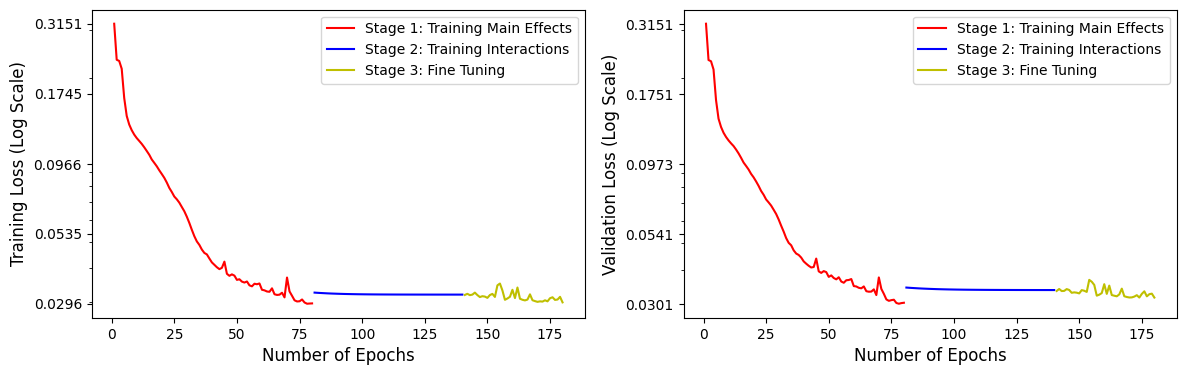

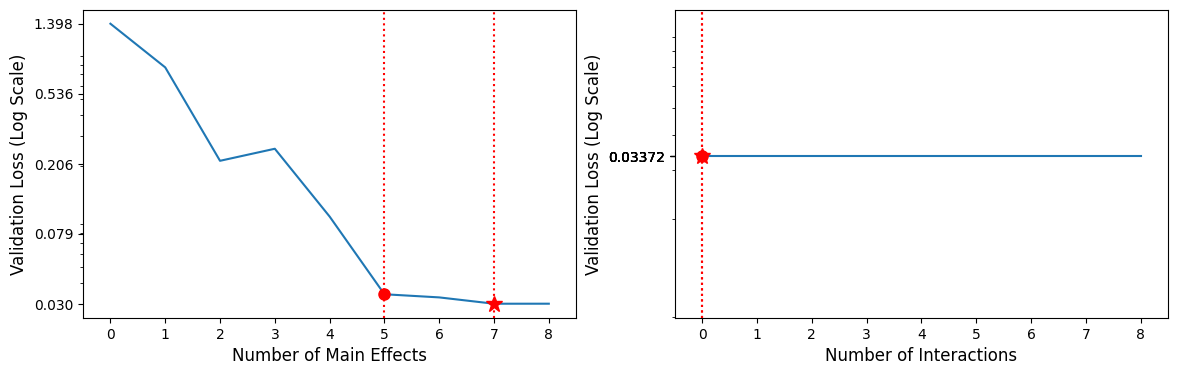

In [ ]:
data_dict_logs = gami_mdl.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs)
plot_regularization(data_dict_logs)

#### Global Interpretation

In [ ]:
data_dict_global = gami_mdl.global_explain(save_dict=True)
feature_importance_visualize(data_dict_global)
plt.show()

AttributeError: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'

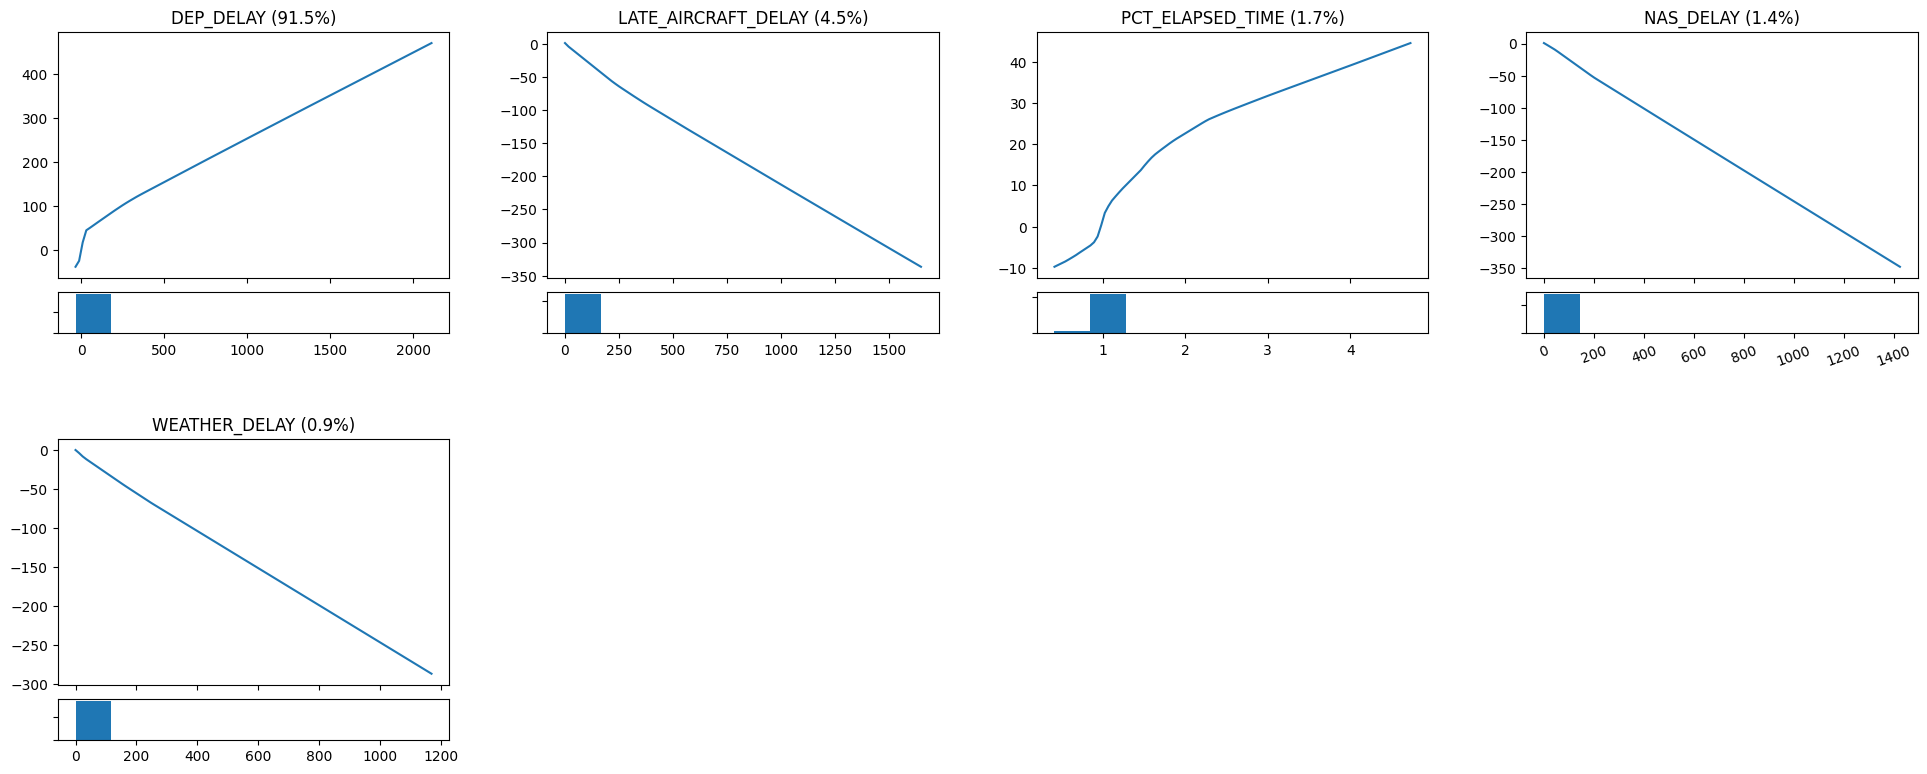

In [ ]:
global_visualize_density(data_dict_global, name="flight_delay_global",
                         main_effect_num=8, interaction_num=1, cols_per_row=4, save_png=True, save_eps=True)

#### Local Interpretation

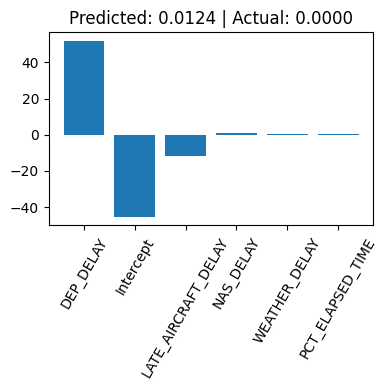

In [ ]:
data_dict_local = gami_mdl.local_explain(X_test_abbrev2[[73]], y_test_class2[[73]], save_dict=False)
local_visualize(data_dict_local[0])
plt.tight_layout()
plt.show()

#### Performance

In [ ]:
y_test_prob = gami_mdl.predict(X_test_abbrev2)
y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
print('accuracy: %.3g, recall: %.3g, roc auc: %.3g, f1: %.3g, mcc: %.3g' %\
      (metrics.accuracy_score(y_test_class2, y_test_pred),\
       metrics.recall_score(y_test_class2, y_test_pred),\
       metrics.roc_auc_score(y_test_class2, y_test_prob),\
       metrics.f1_score(y_test_class2, y_test_pred),\
       metrics.matthews_corrcoef(y_test_class2, y_test_pred)))

accuracy: 0.99, recall: 0.88, roc auc: 0.998, f1: 0.913, mcc: 0.909
